In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import scipy.io
import cv2
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.utils.data
%matplotlib inline
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:500"



/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dev/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:

df=pd.read_csv('/home/dev/Downloads/mpii_dataset.csv')



In [3]:
from sklearn.model_selection import train_test_split
df.drop(['Category','Activity'],1)
df = df.sample(n = len(df)).reset_index(drop=True)

/tmp/ipykernel_14793/934581437.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Category','Activity'],1)


In [4]:
df.head()
from torch.utils.data import Dataset


In [5]:
transferdata_df = df.iloc[- 1400:, 0:]

test_df = pd.DataFrame()
test_df= test_df.append(transferdata_df)
train_df =df.drop(transferdata_df.index)
test_df = test_df.reset_index(drop=True)
test_df.head()

/tmp/ipykernel_14793/1936806666.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df= test_df.append(transferdata_df)


,Unnamed: 0,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,0,087903197.jpg,563,543,587,429,574,368,625,371,...,261,644,243,689,208,667,145,2.070409,"aerobic, step",dancing
1,0,033230991.jpg,294,323,286,247,230,184,200,188,...,90,242,86,260,141,300,166,1.450561,walking the dog,walking
2,0,002198652.jpg,-1,-1,-1,-1,-1,-1,-1,-1,...,451,767,336,848,528,947,566,8.281913,"fishing in stream, in waders (Taylor Code 670)",fishing and hunting
3,0,069666691.jpg,615,885,773,799,822,557,894,566,...,344,897,341,952,404,1029,326,4.766402,"basketball, game (Taylor Code 490)",sports
4,0,055096222.jpg,-1,-1,-1,-1,488,393,486,419,...,184,487,236,494,350,420,344,3.386722,"moving household items upstairs, carrying boxe...",home activities


In [6]:
img_loc=("/home/dev/Downloads/Images/images/")
#imgArray = np.array([])
#files = glob.glob(img_loc+'*.jpg')
imgcomb=[]


images=[]       
trainimglabels=train_df.loc[:,'r ankle_X':'Scale']
trainfilenames=train_df['NAME']

testimglabels=test_df.loc[:,'r ankle_X':'Scale']
testfilenames=test_df['NAME']

class Imagedataset(Dataset):
    def __init__(self,fnames,labels,transform=None):
        self.fnames=fnames
        self.labels=labels
        self.transform=transform
        self.CombArray=np.empty((0,16,2))
        self.BackupLabels=labels

    def __len__(self):
        return len(self.fnames)
    
    def NormaliseData(self,img,idx):
        #print(self.labels.head())
        height, width = img.shape
        #print(self.labels.head())
        Xcoord=[]
        Ycoord=[]
        x=0
        for i in range(0,31,2):
            self.labels.iloc[idx,i]=(self.labels.iloc[idx,i]*(256/width))
            Xcoord.append(self.labels.iloc[idx,i])
            self.labels.iloc[idx,i+1]=(self.labels.iloc[idx,i+1]*(256/height))
            Ycoord.append(self.labels.iloc[idx,i+1])
            x=x+1
        X_min=np.min(Xcoord)
        Y_min=np.min(Ycoord)
        X_max=np.max(Xcoord)
        Y_max=np.max(Ycoord)


    
        self.CombArray = np.concatenate((self.CombArray, np.stack((Xcoord, Ycoord), axis=1)[np.newaxis, :, :]), axis=0)

        x=0
        for i in range(0,31,2):
            self.labels.iloc[idx, i] = (self.labels.iloc[idx, i] - X_min) / (X_max - X_min)
            self.labels.iloc[idx, i+1] = (self.labels.iloc[idx, i+1] - Y_min) / (Y_max - Y_min)
            x=x+1
        #print(self.labels.head())
        normImg=cv2.resize(img,(256,256))
        self.labels.astype(np.float32)
        return normImg
            
    def __getitem__ (self, idx):
        Rimg=cv2.imread(img_loc+self.fnames[idx])
        Gimg=cv2.cvtColor(Rimg,cv2.COLOR_BGR2GRAY)
        Gimg=self.NormaliseData(Gimg,idx)
        #for i in range(0,31,2):
         #   y=self.labels.iloc[idx,i+1]
          #  x=self.labels.iloc[idx,i]
           # cv2.circle(Gimg,(int(x),int(y)),5,(0,255,0),-1)
        #cv2.imshow("gay", Gimg)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
        Gimg = Gimg.astype(np.float32) / 255.
        if self.transform:
            Gimg = self.transform(Gimg)
       
        helper=self.labels.iloc[idx, :-1]
       
        target=helper.values
        target=target.reshape(-1,2)
        target.astype(np.float32)
     
        return (Gimg,target)

    def GetOgLabel(self):
        return (self.CombArray)
        
    def cleanup(self):
        del(self.CombArray)
        del(self.labels)
        self.labels=self.BackupLabels
        self.CombArray=np.empty((0,16,2))
    
train_dataset= Imagedataset(trainfilenames,trainimglabels)
test_dataset= Imagedataset(testfilenames,testimglabels)

train_loader=DataLoader(train_dataset,batch_size=15, shuffle=True, num_workers=4)
test_loader=DataLoader(test_dataset,batch_size=15, shuffle=True)




In [7]:
#data, target= train_dataset.__getitem__(35)
#asdf=pd.DataFrame(data)
#a=train_dataset.GetOgLabel()


In [8]:

#train_dataset.cleanup()

In [9]:

#print(a[0,:,0],'\t' ,a.shape)

In [10]:
#train_dataset.fnames.iloc[4]
import itertools

In [11]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
   
        self.fc1 = nn.Linear(64*64*64,64)
        self.fc2 = nn.Linear(64,16*2)
        

    def forward(self, X):
        X = self.conv1(X)
        X = F.leaky_relu(X)
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = self.conv2(X)
        X = F.leaky_relu(X)
     
        X = F.max_pool2d(X,kernel_size=2,stride=2)

        X = torch.flatten(X,1)
        X = self.fc1(X)
        X = F.leaky_relu(X)
        X = self.fc2(X)
        X = F.leaky_relu(X)
        

        X=X.view(-1,16,2)
        output =X
        return output
    
torch.manual_seed(101)
model = ConvolutionalNetwork().to(dev)
print(dev)

cuda:0


In [12]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.000001,weight_decay=0.00005)

In [13]:
def train(model, dev, train_loader, optimizer):
  
  model.train()
  EPOCHS = 50
  batch_size = 15
  id=0
  #for batch_idx in range(0,len(train_loader),batch_size):
  for epoch in range(EPOCHS):
    id=0
    print("Loading Epoch...")
    train_dataset.cleanup()  
    for data, target in train_loader:
        
      data=data.unsqueeze(1)
      #print("dik")
      #start_idx = batch_idx
      #end_idx = min(len(train_loader), batch_idx + 20)
    # batch=list(itertools.islice(train_loader,batch_size))
      ###for data, target in batch:
        #print("coc")
      #print(data.shape ," MIAGECI ",target.shape)
      data, target = data.to(dev), target.to(dev)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output.float(), target.float())
      loss.backward()
  
      
      optimizer.step()
     # if(id%15==0):
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
        epoch, id * len(data), len(train_loader.dataset),
        100. * id / len(train_loader), loss.item()))
      if(id*len(data)==3000):
        break   
      id=id+1
    
        

In [14]:

#train_dataset.__getitem__(0)
#test_dataset.__getitem__(2)


In [15]:
torch.cuda.empty_cache()

In [16]:

 train(model, dev, train_loader, optimizer)

Loading Epoch...
Train Epoch: 0 [0/15972 (0%)]	Loss: 0.340
Train Epoch: 0 [15/15972 (0%)]	Loss: 0.330
Train Epoch: 0 [30/15972 (0%)]	Loss: 0.325
Train Epoch: 0 [45/15972 (0%)]	Loss: 0.297
Train Epoch: 0 [60/15972 (0%)]	Loss: 0.330
Train Epoch: 0 [75/15972 (0%)]	Loss: 0.314
Train Epoch: 0 [90/15972 (1%)]	Loss: 0.349
Train Epoch: 0 [105/15972 (1%)]	Loss: 0.286
Train Epoch: 0 [120/15972 (1%)]	Loss: 0.317
Train Epoch: 0 [135/15972 (1%)]	Loss: 0.291
Train Epoch: 0 [150/15972 (1%)]	Loss: 0.325
Train Epoch: 0 [165/15972 (1%)]	Loss: 0.290
Train Epoch: 0 [180/15972 (1%)]	Loss: 0.269
Train Epoch: 0 [195/15972 (1%)]	Loss: 0.260
Train Epoch: 0 [210/15972 (1%)]	Loss: 0.279
Train Epoch: 0 [225/15972 (1%)]	Loss: 0.275
Train Epoch: 0 [240/15972 (2%)]	Loss: 0.249
Train Epoch: 0 [255/15972 (2%)]	Loss: 0.255
Train Epoch: 0 [270/15972 (2%)]	Loss: 0.237
Train Epoch: 0 [285/15972 (2%)]	Loss: 0.223
Train Epoch: 0 [300/15972 (2%)]	Loss: 0.287
Train Epoch: 0 [315/15972 (2%)]	Loss: 0.246
Train Epoch: 0 [330/159

KeyboardInterrupt: 

In [17]:
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    device = next(model.parameters()).device
    
    
    mpjpe = 0.0
    num_samples = 0
    mse = 0.0
    rmse = 0.0
    ssr = 0.0
    sst = 0.0
    with torch.no_grad():
        for data, target in data_loader:
            data=data.unsqueeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
        #MPJPE
            batch_mpjpe = torch.sqrt(torch.sum((output - target)**2, dim=-1)).mean()
            mpjpe += batch_mpjpe.item() * data.size(0)
            num_samples += data.size(0)
        #MSE
       
            batch_mse = loss.item() * data.size(0)
            mse += batch_mse
        
        #RMSE 
            batch_rmse = torch.sqrt(loss).item() * data.size(0)
            rmse += batch_rmse
        
        #SSR and SST 
            batch_ssr = torch.sum((output - target)**2).item()
            batch_sst = torch.sum((target - torch.mean(target))**2).item()
            ssr += batch_ssr
            sst += batch_sst
        
            num_samples += data.size(0)
    
    num_samples_total = num_samples * data_loader.batch_size   
    r2 = 1.0 - (ssr / sst)
    
    mse /= num_samples
    rmse /= num_samples
 
    avg_mpjpe = mpjpe / num_samples_total

    
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2 score: {r2:.4f}, MPJPE: {mpjpe:.4f}')
            
   


In [18]:
 evaluate(model, test_loader)


MSE: 0.0519, RMSE: 0.1609, R2 score: -0.0379, MPJPE: 561.0704


In [19]:
def predict_image(model, test_loader, device):
   
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        predictions_denorm=[]
        for i, (data, target) in enumerate(test_loader):
            if i== 1:
                break
            data=data.unsqueeze(1)
            data=data.to(dev)
            predictions = model(data)

            predictions = predictions.cpu().numpy()
            print(predictions.shape)
            target = target.cpu().numpy()
            OgValues=test_dataset.GetOgLabel()
            ogX=[]
            ogY=[]
            for i in range(predictions.shape[0]):
                for k in range(OgValues.shape[1]):
                    ogX.append(OgValues[i,k,0])
                    ogY.append(OgValues[i,k,1])
                X_min=np.min(ogX)
                Y_min=np.min(ogY)
                X_max=np.max(ogX)
                Y_max=np.max(ogY)
                for j in range(predictions.shape[1]):
                    
                    predictions[i,j,0] = predictions[i, j, 0] * (X_max-X_min)+X_min 
                    predictions[i,j,1] = predictions[i, j, 1] * (Y_max-Y_min)+Y_min  
                    print(predictions[i,j,1])
                    print(predictions[i,j,0])

            test_dataset.cleanup()
            # Plot the images with predicted keypoints
            for i in range(len(data)):
                img_data = np.transpose(data[i].cpu().numpy(), (1, 2, 0))
                img_data=img_data*255
                plt.imshow(img_data)
                plt.scatter(predictions[i][::2], predictions[i][1::2] , s=50)
                plt.show()


(15, 16, 2)
153.5929
94.91405
160.04892
112.74219
154.59853
118.00236
163.82709
94.79426
146.058
116.0541
140.63678
112.602005
167.19809
122.01857
55.054012
122.43853
98.95056
119.14103
80.13856
121.882774
156.07555
112.70004
134.55122
114.439026
55.499474
118.348404
99.24096
126.16818
149.19205
126.75531
158.61105
127.94135
173.25725
-0.47680297
179.78053
60.952393
175.54889
84.17794
182.8541
-1.0153388
143.70198
93.76016
153.17188
60.677822
195.50595
108.15942
-1.7839346
111.021835
74.68756
95.36897
46.34109
108.38073
144.07576
68.2159
143.60332
76.86943
-1.0258503
93.19995
88.02608
118.89797
151.83502
121.251495
152.17456
122.58113
152.24603
-0.4979212
160.08131
62.236214
153.5151
82.10508
157.06903
-0.9749349
147.77417
85.00301
145.03894
65.10813
157.27322
96.16336
-1.6233995
98.13471
67.158264
91.360504
39.296635
95.93074
138.48602
68.61265
114.5082
77.38236
-0.9150663
86.32534
69.25833
108.75754
130.53471
113.78881
145.01231
115.26106
152.25995
-0.54970294
151.72069
61.274246
144

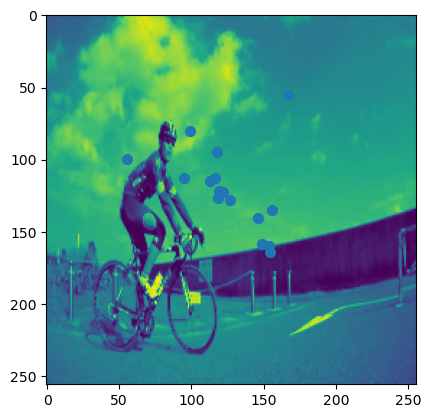

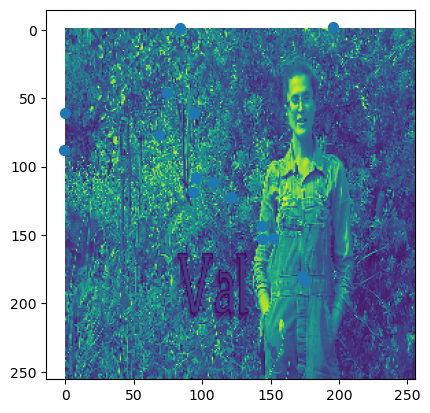

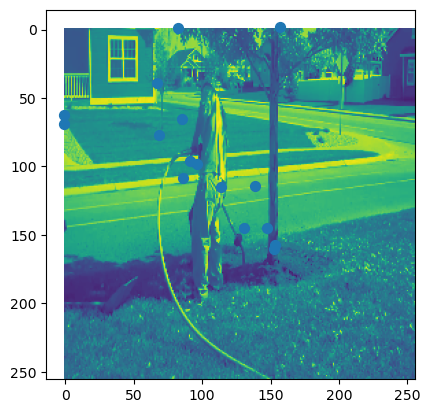

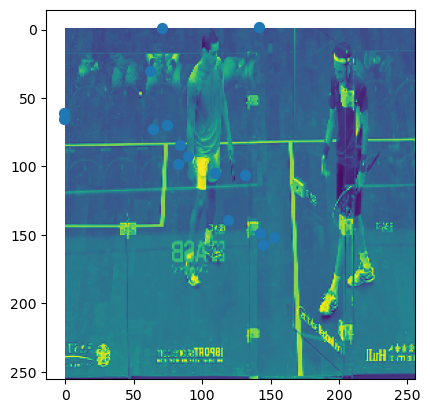

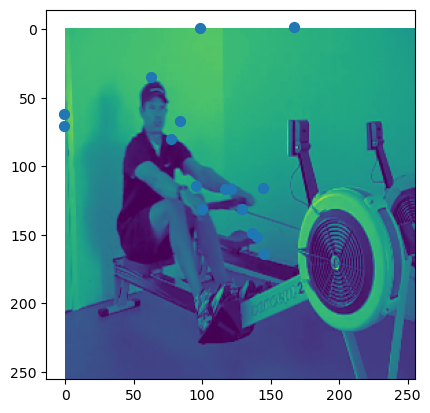

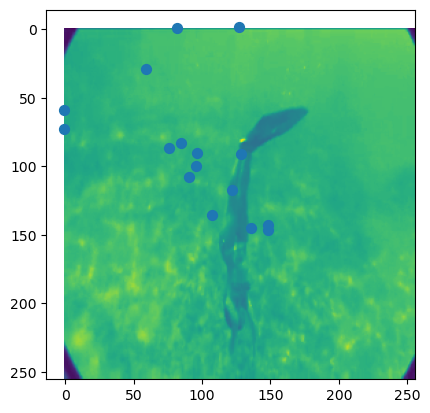

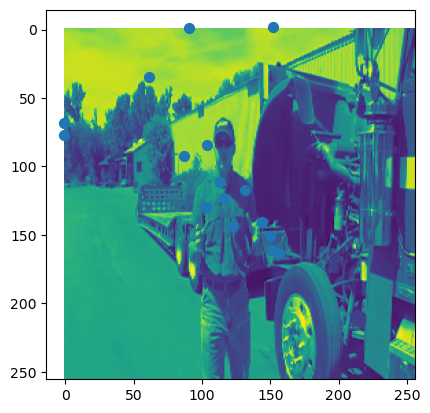

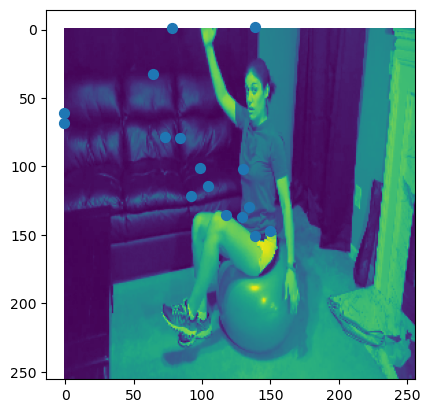

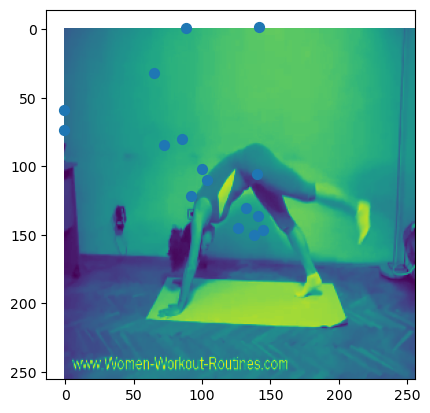

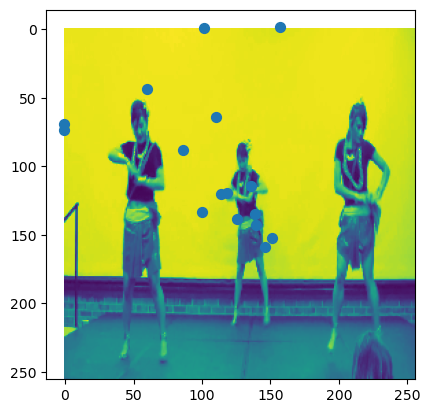

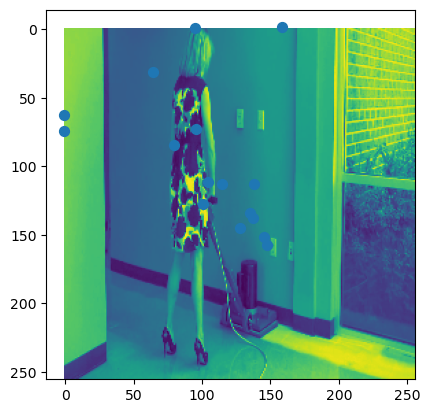

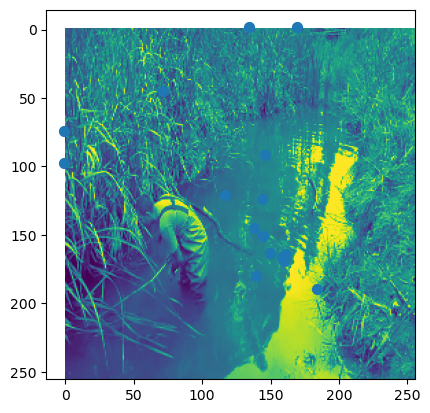

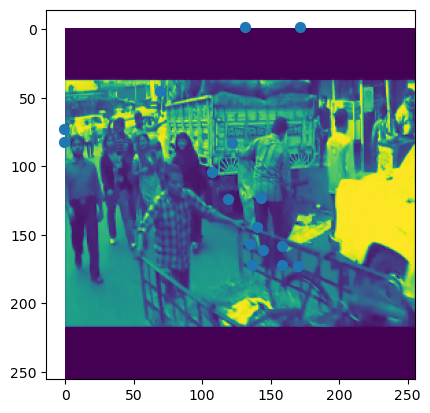

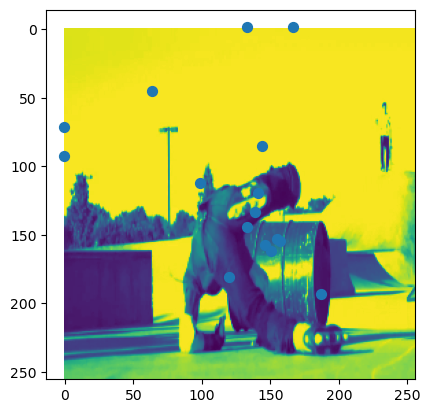

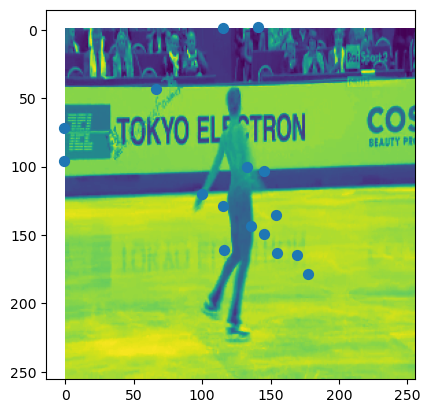

In [20]:
predict_image(model, test_loader, dev)